In [0]:
!pip install -q 'gwpy==1.0.1'

In [0]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

In [0]:
!pip install gwpy lalsuite

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install PyDrive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1681WuONd9kH1x0TucOEW-zCiVb18DeSH"})   # replace the id with id of file you want to access
downloaded.GetContentFile('challenge3.gwf')   

In [0]:
from gwpy.timeseries import TimeSeries
data1= TimeSeries.read('challenge3.gwf', 'H1:CHALLENGE3')
data2=TimeSeries.read('challenge3.gwf', 'L1:CHALLENGE3')

In [0]:
import numpy as np
signal1=np.array(data1)
signal2=np.array(data2)

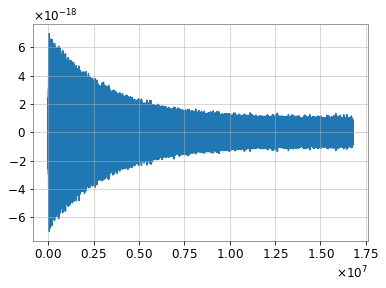

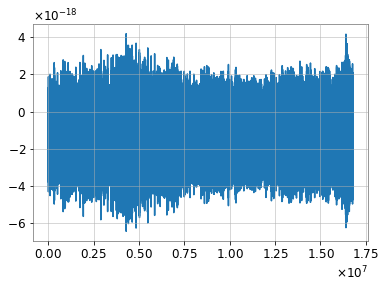

In [0]:
import matplotlib.pyplot as plt

plt.plot(signal1)
plt.show()
plt.plot(signal2)
plt.show()

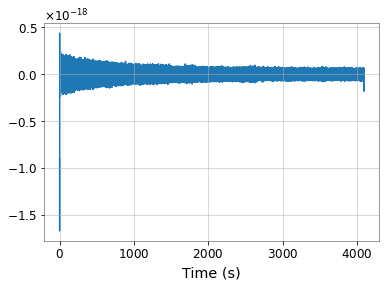

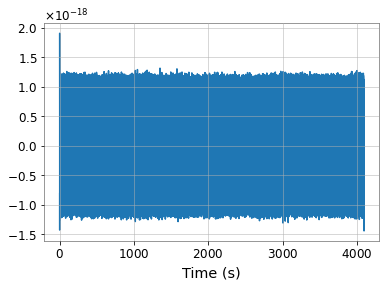

In [0]:
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.types import TimeSeries
import pylab
gw_timeseries1 = TimeSeries(signal1, delta_t=1/4096, epoch=0)


# Remove the low frequency content and downsample the data to 2048Hz
gw_timeseries1 = resample_to_delta_t(highpass(gw_timeseries1, 15.0), 1.0/2048)

pylab.plot(gw_timeseries1.sample_times, gw_timeseries1)
pylab.xlabel('Time (s)')
pylab.show()
gw_timeseries2 = TimeSeries(signal2, delta_t=1/4096, epoch=0)


# Remove the low frequency content and downsample the data to 2048Hz
gw_timeseries2 = resample_to_delta_t(highpass(gw_timeseries2, 15.0), 1.0/2048)

pylab.plot(gw_timeseries2.sample_times, gw_timeseries2)
pylab.xlabel('Time (s)')
pylab.show()

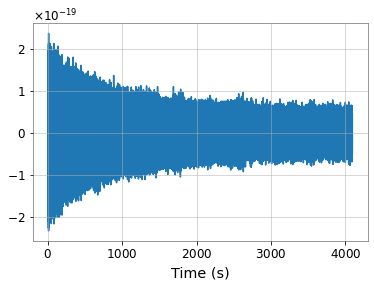

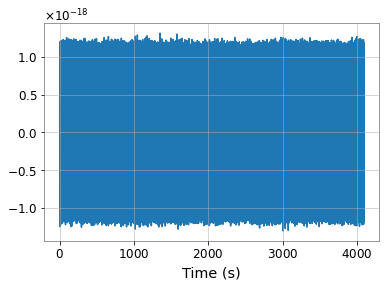

In [0]:
strain1=gw_timeseries1
conditioned1 = strain1.crop(2, 2)

pylab.plot(conditioned1.sample_times, conditioned1)
pylab.xlabel('Time (s)')
pylab.show()
strain2=gw_timeseries2
conditioned2 = strain2.crop(2, 2)

pylab.plot(conditioned2.sample_times, conditioned2)
pylab.xlabel('Time (s)')
pylab.show()

In [0]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samles of our time series in Welch method.
psd1 = conditioned1.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd1 = interpolate(psd1, conditioned1.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency. 
psd1 = inverse_spectrum_truncation(psd1, 4 * conditioned1.sample_rate,
                                  low_frequency_cutoff=20)
# We use 4 second samles of our time series in Welch method.
psd2 = conditioned2.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner

psd2 = interpolate(psd2, conditioned2.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to informat the function to not include frequencies
# below this frequency. 
psd2 = inverse_spectrum_truncation(psd2, 4 * conditioned2.sample_rate,
                                  low_frequency_cutoff=20)

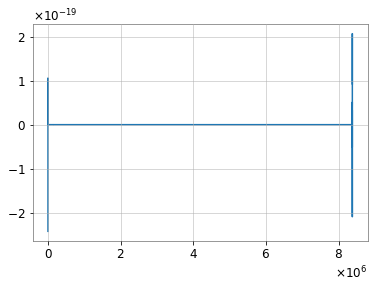

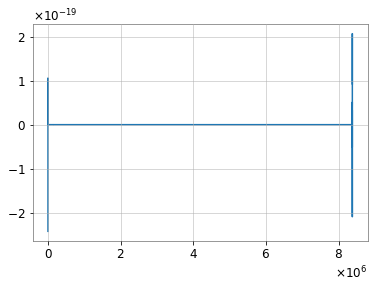

In [0]:
x=10
from pycbc.waveform import get_td_waveform
hp1, hc1 = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=x,
                     mass2=x,
                     delta_t=conditioned1.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp1.resize(len(conditioned1))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
template1 = hp1.cyclic_time_shift(hp.start_time)
pylab.plot(template1)
pylab.show()
hp2, hc2 = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=x,
                     mass2=x,
                     delta_t=conditioned2.delta_t,
                     f_lower=20)

# We will resize the vector to match our data
hp2.resize(len(conditioned2))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# This function rotates the vector by a fixed amount of time.
# It treats the data as if it were on a ring. Note that
# time stamps are *not* in general affected, but the true
# position in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
template2 = hp.cyclic_time_shift(hp.start_time)
pylab.plot(template2)
pylab.show()

In [0]:
massac=[]
import tensorflow as tf

for x in range(10,51):
  print(x)
  from pycbc.waveform import get_td_waveform
  hp1, hc1 = get_td_waveform(approximant="SEOBNRv4_opt",
                      mass1=x,
                      mass2=x,
                      delta_t=conditioned1.delta_t,
                      f_lower=20)

  # We will resize the vector to match our data
  hp1.resize(len(conditioned1))
  template1 = hp1.cyclic_time_shift(hp1.start_time)
  from pycbc.filter import matched_filter
  import numpy

  snr1 = matched_filter(template1, conditioned1,
                      psd=psd1, low_frequency_cutoff=20)


  snr1 = snr1.crop(4 + 4, 4)


  peak1 = abs(snr1).numpy().argmax()
  snrp1 = snr1[peak1]
  time1 = snr1.sample_times[peak1]

  print("We found a apparant signal at {}s with SNR {} in H1".format(time1, 
                                                      abs(snrp1)))
  hp2, hc2 = get_td_waveform(approximant="SEOBNRv4_opt",
                      mass1=x,
                      mass2=x,
                      delta_t=conditioned2.delta_t,
                      f_lower=20)

  # We will resize the vector to match our data
  hp2.resize(len(conditioned2))
  template2 = hp2.cyclic_time_shift(hp2.start_time)

  snr2 = matched_filter(template2, conditioned2,
                      psd=psd2, low_frequency_cutoff=20)


  snr2 = snr2.crop(4 + 4, 4)

  peak2 = abs(snr2).numpy().argmax()
  snrp2 = snr2[peak2]
  time2 = snr2.sample_times[peak2]

  print("We found a apparent signal at {}s with SNR {} in L1".format(time2, 
                                                      abs(snrp2)))
  if time1==time2:
    print("Peak Time match ____________________________________________________________________________________________________________________________________________________________________________________________________________--Peak Time Match")
    from pycbc.filter import sigma
    dt1 = time1 - conditioned1.start_time
    aligned1 = template1.cyclic_time_shift(dt1)

    # scale the template so that it would have SNR 1 in this data
    aligned1 /= sigma(aligned1, psd=psd1, low_frequency_cutoff=20.0)

    # Scale the template amplitude and phase to the peak value
    aligned1 = (aligned1.to_frequencyseries() * snrp1).to_timeseries()
    aligned1.start_time = conditioned1.start_time
    # We do it this way so that we can whiten both the template and the data
    white_data1 = (conditioned1.to_frequencyseries() / psd1**0.5).to_timeseries()

    # apply a smoothing of the turnon of the template to avoid a transient
    # from the sharp turn on in the waveform.
    tapered1 = aligned1.highpass_fir(30, 512, remove_corrupted=False)
    white_template1 = (tapered1.to_frequencyseries() / psd1**0.5).to_timeseries()

    white_data1 = white_data1.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template1 = white_template1.highpass_fir(30, 512).lowpass_fir(300, 512)

    # Select the time around the merger
    white_data1 = white_data1.time_slice(time1-0.2, time1+.10)
    white_template1 = white_template1.time_slice(time1-0.2, time1+.10)
    dt2 = time2 - conditioned2.start_time
    aligned2 = template2.cyclic_time_shift(dt2)

    # scale the template so that it would have SNR 1 in this data
    aligned2 /= sigma(aligned2, psd=psd2, low_frequency_cutoff=20.0)

    # Scale the template amplitude and phase to the peak value
    aligned2 = (aligned2.to_frequencyseries() * snrp2).to_timeseries()
    aligned2.start_time = conditioned2.start_time
    # We do it this way so that we can whiten both the template and the data
    white_data2 = (conditioned2.to_frequencyseries() / psd2**0.5).to_timeseries()

    # apply a smoothing of the turnon of the template to avoid a transient
    # from the sharp turn on in the waveform.
    tapered2 = aligned2.highpass_fir(30, 512, remove_corrupted=False)
    white_template2 = (tapered2.to_frequencyseries() / psd2**0.5).to_timeseries()

    white_data2 = white_data2.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template2 = white_template2.highpass_fir(30, 512).lowpass_fir(300, 512)

    # Select the time around the merger
    white_data2 = white_data2.time_slice(time2-0.2, time2+.10)
    white_template2 = white_template2.time_slice(time2-0.2, time2+.10)
    print('and mean abs error='+str(tf.keras.metrics.mean_absolute_error(white_data1,white_template1).numpy())+','+str(tf.keras.metrics.mean_absolute_error(white_data2,white_template2).numpy()))

    massac.append(x)

10
We found a apparant signal at 2483.96728515625s with SNR 28.875743646459355 in H1
We found a apparent signal at 2483.96728515625s with SNR 33.52902527302097 in L1
Peak Time match ____________________________________________________________________________________________________________________________________________________________________________________________________________--Peak Time Match
and mean abs error=12.176302002655058,13.527049007366733
11
We found a apparant signal at 1204.712890625s with SNR 12.31173411852727 in H1
We found a apparent signal at 2483.953125s with SNR 10.824054606427413 in L1
12
We found a apparant signal at 1204.7119140625s with SNR 13.677365315411699 in H1
We found a apparent signal at 1204.71728515625s with SNR 12.513576969957578 in L1
13
We found a apparant signal at 1204.71240234375s with SNR 16.384654320240685 in H1
We found a apparent signal at 1204.7119140625s with SNR 13.22492729195864 in L1
14
We found a apparant signal at 1638.158203125s 